In [1]:
import nengo
import numpy as np
import pylab as plt
from nengo.utils.matplotlib import rasterplot

%matplotlib widget

# Use NxSDK backend on Loihi
import nengo_loihi
nengo_loihi.set_defaults()

ModuleNotFoundError: No module named 'nengo_loihi'

In [165]:
img_shape = (10, 10, 1)

def input_func(t):
    data = [np.sin(t*4), 2*np.exp(-t)]
    return data

with nengo.Network(label="Control") as net:
    nengo_loihi.add_params(net)
    
    inp = nengo.Node(output=input_func)
    ens1 = nengo.Ensemble(n_neurons=40, dimensions=inp.size_out)
    ens2 = nengo.Ensemble(n_neurons=50, dimensions=ens1.size_out)
    nengo.Connection(inp, ens1)
    conn = nengo.Connection(ens1, ens2, solver=nengo.solvers.LstsqL2(weights=True))
    p = nengo.Probe(inp, synapse=0.01)
    spk_ens1 = nengo.Probe(ens1.neurons, synapse=0.01)
    spk_ens2 = nengo.Probe(ens2.neurons, synapse=0.01)
    # weights_p = nengo.Probe(conn, "weights", synapse=0.01, sample_every=0.01)

In [171]:
with nengo.Simulator(net, seed=0, dt=1e-3) as sim:
    sim.run(1)
t = sim.trange()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [166]:
with nengo_loihi.Simulator(net, seed=1, dt=1e-3) as sim:
    sim.run(5)
t = sim.trange()

INFO:DRV:  Connecting to 127.0.0.1:40655
INFO:DRV:      Host server up..............Done 0.79s
INFO:DRV:      Encoding axons/synapses.....Done 4.20ms
INFO:DRV:      Compiling Embedded snips....Done 0.14s
INFO:DRV:      Compiling MPDS Registers....Done 0.39ms
INFO:DRV:      Booting up..................Done 2.03s
INFO:DRV:      Encoding probes.............Done 0.42ms
INFO:DRV:      Transferring probes.........Done 1.85ms
INFO:DRV:      Configuring registers.......Done 9.26ms
INFO:DRV:      Transferring spikes.........Done 0.07s
INFO:DRV:      Executing...................Done 20.32s
INFO:DRV:      Processing timeseries.......Done 0.04s
INFO:DRV:  Executor: 5000 timesteps........Done 20.46s
INFO:HST:  Using Kapoho Bay serial number 446
INFO:HST:  Args chip=0 cpu=0 /loihi/lib/python3.8/site-packages/nxsdk/driver/compilers/../../../temp/1664464837.7474365/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 
INFO:HST:  Nx...
INFO:HST:  chip=0 cpu=0 halted, status=0x0


Text(0.5, 0.98, 'Tactile Stimuli')

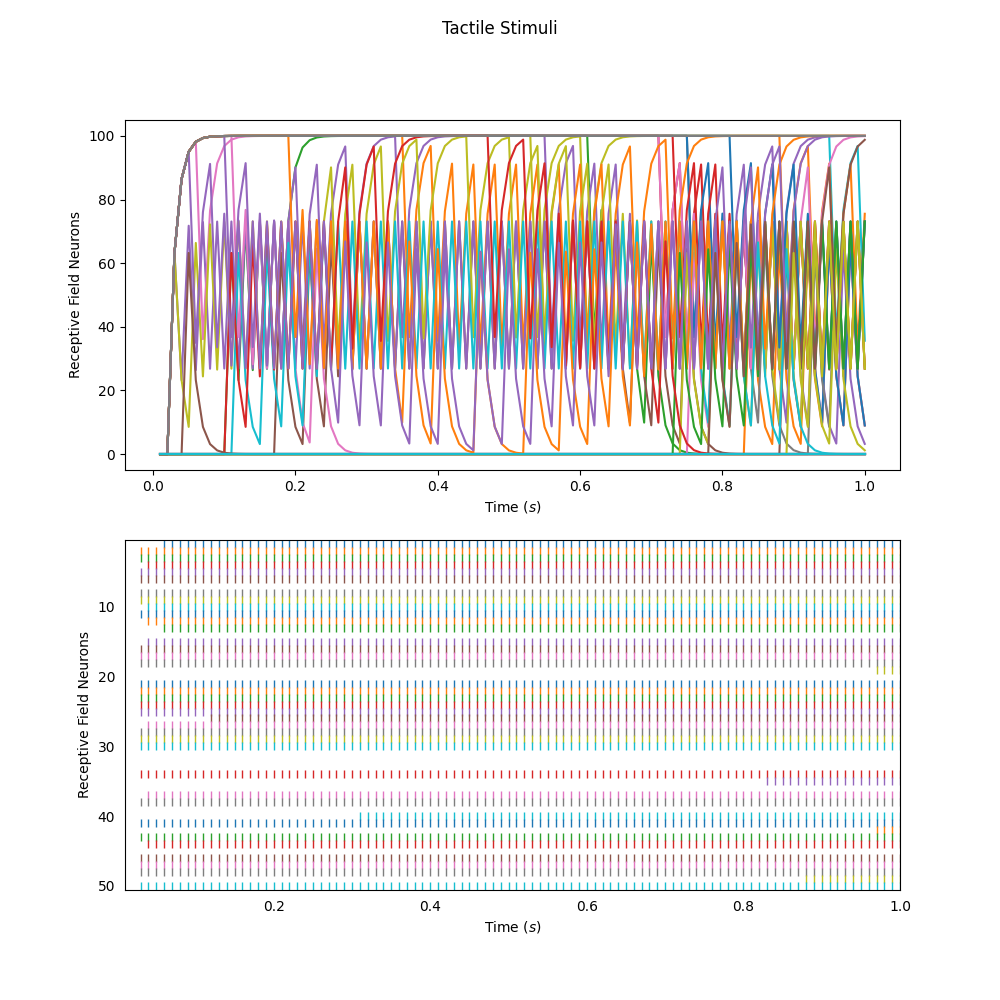

In [172]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[spk_ens1])
plt.xlabel(r"Time ($s$)")
plt.ylabel("Receptive Field Neurons")
plt.subplot(2, 1, 2)
rasterplot(sim.trange(), sim.data[spk_ens2])
plt.xlabel(r"Time ($s$)")
plt.ylabel("Receptive Field Neurons")
plt.suptitle("Tactile Stimuli")

# Proactive Control with Inhibitory Motor Neuron Demo

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

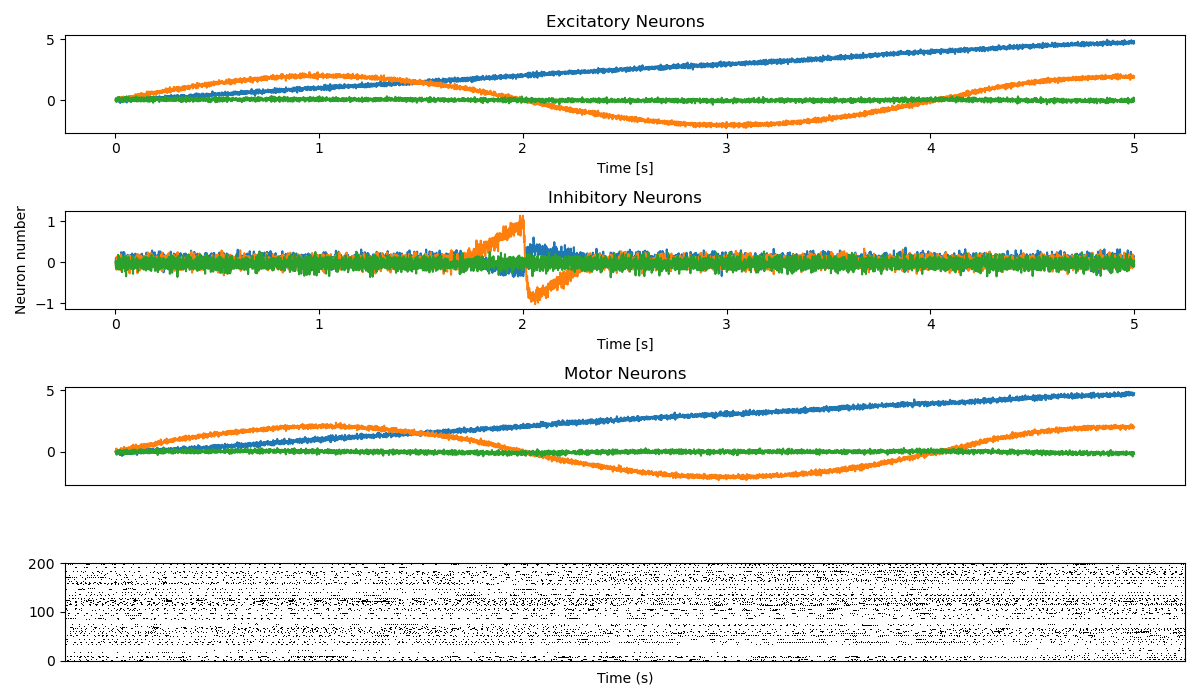

In [442]:
import nengo
import numpy as np
import pylab as plt
from nengo.utils.matplotlib import rasterplot
from nengo_extras.plot_spikes import (
    plot_spikes
)

%matplotlib widget

T = 5
p = [2.0, 0, 0]
r = 1

def exc_func(t):
    return [t, 2*np.sin(0.5*np.pi*t), 0]

def inh_func(t):
    x = exc_func(t)
    v = np.asarray(p) - np.asarray(x)
    v_n = np.linalg.norm(v)
    if v_n <= r:
        dx = (r - v_n)*v/v_n
    else:
        dx = [0, 0, 0]
    return dx

with nengo.Network(label="Motor Neurons") as model:
    # Defines excitatory input
    exc_in = nengo.Node(output=exc_func)
    exc_ens = nengo.Ensemble(n_neurons=200, dimensions=3, radius=T)
    nengo.Connection(exc_in, exc_ens)
    
    # Defines inhibitory input
    inh_in = nengo.Node(output=inh_func)
    inh_ens = nengo.Ensemble(n_neurons=200, dimensions=3, radius=T)
    nengo.Connection(inh_in, inh_ens, transform=[-1]*3)
    
    # Defines motor neurons
    out = nengo.Ensemble(n_neurons=200, dimensions=3, radius=T)
    nengo.Connection(exc_ens, out)
    #nengo.Connection(inh_ens, out)
    
    exc_probe = nengo.Probe(exc_ens, synapse=0.01)
    exc_n_probe = nengo.Probe(exc_ens.neurons)
    inh_probe = nengo.Probe(inh_ens, synapse=0.01)
    inh_n_probe = nengo.Probe(inh_ens.neurons)
    out_probe = nengo.Probe(out, synapse=0.01)
    out_n_probe = nengo.Probe(out.neurons)
    
def plot_decoded(t, data):
    plt.figure(figsize=(12, 7))
    
    plt.subplot(4, 1, 1)
    plt.title("Excitatory Neurons")
    plt.plot(t, data[exc_probe])
    plt.xlabel("Time [s]")
    plt.subplot(4, 1, 2)
    plt.title("Inhibitory Neurons")
    plt.plot(t,data[inh_probe])
    plt.xlabel("Time [s]")
    plt.ylabel("Neuron number")
    
    plt.subplot(4, 1, 3)
    plt.title("Motor Neurons")
    plt.plot(t, data[out_probe])
    plt.xticks(())
    plt.subplot(4, 1, 4)
    plot_spikes(t, data[out_n_probe])
    plt.xticks(())
    plt.xlabel("Time (s)")
    
    plt.tight_layout()

with nengo.Simulator(model, dt=1e-3) as sim:
    sim.run(T)
t = sim.trange()
    
plot_decoded(t, sim.data)

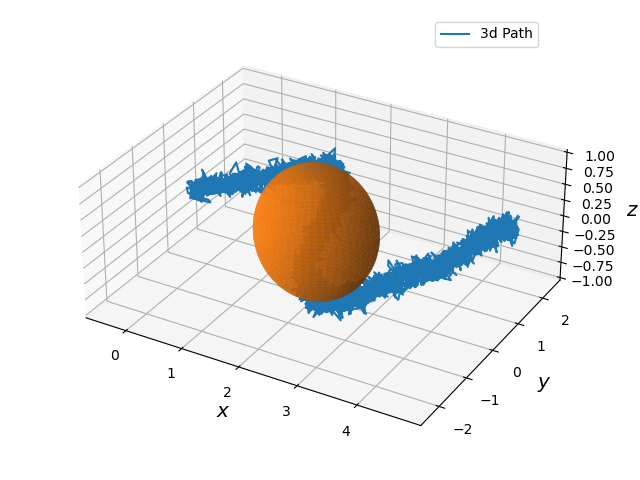

In [441]:
def plot_3d(data):
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(data[out_probe][:, 0], data[out_probe][:, 1], data[out_probe][:, 2], label='3d Path')
    ax.set_xlabel("$x$", fontsize="x-large")
    ax.set_ylabel("$y$", fontsize="x-large")
    ax.set_zlabel("$z$", fontsize="x-large")
    ax.legend()
    
    # Make data
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = p[0] + r*np.outer(np.cos(u), np.sin(v))
    y = p[1] + r*np.outer(np.sin(u), np.sin(v))
    z = p[2] + r*np.outer(np.ones(np.size(u)), np.cos(v))

    # Plot the surface
    ax.plot_surface(x, y, z, alpha=0.8)
    ax.set_box_aspect([T/2, 2, 1], zoom=1.1)

plot_3d(sim.data)
plt.tight_layout()